# Question A3

Find the optimal number of hidden neurons for first hidden layer of the 4-layer network (3 hidden layers, output layer) designed in Question 1 and 2

#### Plot the mean cross-validation accuracies on the final epoch for different numbers of hidden-layer neurons using a scatter plot. Limit the search space of the number of neurons to {64, 128, 256}. Continue using 5-fold cross validation on training dataset. Select the optimal number of neurons for the hidden layer. State the rationale for your selection.

This might take a while to run, approximately 20 - 30 min, so plan your time carefully.

1. Firstly, we import relevant libraries.

In [1]:
import time
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

# Import custom utility functions
from common_utils import set_seed, split_dataset, preprocess_dataset, generate_cv_folds_for_num_neurons, generate_cv_dataloaders, EarlyStopper

# setting seed
SEED = 42
set_seed(SEED)

2. To reduce repeated code, place your

- network (MLP defined in QA1)
- torch datasets (CustomDataset defined in QA1)
- loss function (loss_fn defined in QA1)

in a separate file called **common_utils.py**

Import them into this file. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked.

The following code cell will not be marked.

In [2]:
# YOUR CODE HERE
from common_utils import MLP, CustomDataset, loss_fn

In [3]:
# Import Dataset & Conduct Train-test split

# Loading the dataset from a CSV file.
df = pd.read_csv('simplified.csv')
set_seed(SEED)

# Extracting the 'label' from the 'filename' column.
# It appears the label is embedded in the filename and is the penultimate (second last) item when split by '_'.
df['label'] = df['filename'].str.split('_').str[-2]

# Checking the distribution of the labels.
print(df['label'].value_counts())

# Dropping Unnecessary Columns and Splitting the Dataset:
# The dataset column called filename is likely a unique identifier for each sample and not a feature we would use for modeling. Hence, we should remove it before feeding the data to our model. 
columns_to_drop = ['filename', 'label']  

# Splitting the dataset into training and testing sets:
# The split is done in a 70:30 ratio, and the random_state ensures reproducibility.
X_train, y_train, X_test, y_test = split_dataset(df, columns_to_drop, test_size=0.3, random_state=SEED)

# We do not do preprocessing here as we will be doing 5-fold CV here. We should be applying scaling within each fold of the cross-validation, rather than fitting a scaler on the entire training dataset beforehand. 
# In each fold of the 5-fold cross-validation, a portion of our training set becomes the "validation" set, so the scaling parameters might be slightly different for each fold.

# Declare a global dictionary to store epoch accuracies for different neurons in the first hidden layer
global_epoch_accuracies = {}

label
pos    6202
neg    5855
Name: count, dtype: int64


3. Perform hyperparameter tuning for the different neurons with 5-fold cross validation.

In [4]:
def train(model, X_train_scaled, y_train2, X_val_scaled, y_val2, batch_size):
    # Initialize dataset and dataloaders using the provided scaled training and validation sets
    train_dataloader, val_dataloader = generate_cv_dataloaders(X_train_scaled, y_train2, X_val_scaled, y_val2, batch_size)
    
    # Set up the optimizer with learning rate of 0.001
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    # Set up the binary cross-entropy loss function
    loss_fn = nn.BCELoss()
    
    # Initialize the early stopping mechanism with a patience of 3 (number of epochs without improvement)
    early_stopper = EarlyStopper(patience=3)

    # Lists to store train accuracies, train losses, test accuracies, test losses and epoch times
    train_accuracies = []
    train_losses = []
    test_accuracies = []
    test_losses = []
    times = []

    # Training loop for up to 100 epochs
    for epoch in tqdm(range(100)):
        # Record start time of the epoch
        start_time = time.time()
        # Set model to training mode
        model.train()
        # Initialize variables for calculating training accuracy and loss
        correct_train = 0
        total_train = 0
        train_loss = 0.0
        
        # Loop through each batch in the training set
        for batch in train_dataloader:
            # Split the batch into data and target
            data, target = batch
            # Reset gradients to zero
            optimizer.zero_grad()
            
            # Forward pass: compute model's predictions
            output = model(data)
            # Calculate the loss between the predictions and the ground truth
            loss = loss_fn(output, target.float())
            # Backward pass: compute the gradient of the loss wrt model parameters
            loss.backward()
            # Update the model parameters using the computed gradients
            optimizer.step()
            
            # Update train loss
            train_loss += loss.item()
            # Convert model's predictions to binary (0 or 1)
            predicted = torch.round(output)
            # Update the number of total and correctly predicted samples
            total_train += target.size(0)
            correct_train += (predicted == target).sum().item()
        
        # Compute training accuracy and update the list
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)
        # Update the train losses list
        train_losses.append(train_loss)
        
        # Set model to evaluation mode for validation
        model.eval()
        # Initialize variables for calculating validation loss and accuracy
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        
        # Disable gradient computation for efficiency during validation
        with torch.no_grad():
            # Loop through each batch in the validation set
            for batch in val_dataloader:
                data, target = batch
                output = model(data)
                loss = loss_fn(output, target.float())
                val_loss += loss.item()
                
                # Convert model's predictions to binary (0 or 1)
                predicted = torch.round(output)
                # Update the number of total and correctly predicted samples
                correct_predictions = (predicted == target).sum().item()
                total_val += target.size(0)
                correct_val += correct_predictions

        # Compute validation accuracy and update the list
        test_accuracy = correct_val / total_val
        test_accuracies.append(test_accuracy)
        # Update the validation losses list
        test_losses.append(val_loss)
                
        # Check if early stopping should be triggered based on validation loss
        if early_stopper.early_stop(val_loss):
            # Record the end time of the epoch
            end_time = time.time()
            # Compute the elapsed time for the epoch
            elapsed_time = end_time - start_time
            # Update the list of epoch times
            times.append(elapsed_time)
            # Print a message indicating early stopping was triggered
            print(f"Early stopping triggered at epoch {epoch+1}!")
            break
        
        # Record the end time of the epoch if not early-stopped
        end_time = time.time()
        # Compute the elapsed time for the epoch
        elapsed_time = end_time - start_time
        # Update the list of epoch times
        times.append(elapsed_time)
            
    # Return the recorded metrics: train accuracies, train losses, test accuracies, test losses, and epoch times
    return train_accuracies, train_losses, test_accuracies, test_losses, times


In [22]:
def find_optimal_hyperparameter(X_train, y_train, parameters, mode, batch_size):
    # Access the global variable to store epoch accuracies
    global global_epoch_accuracies

    # Dictionaries to store cross-validation accuracies and times
    cross_validation_accuracies = {}
    cross_validation_times = {}

    # Iterate through the specified parameters
    for param in parameters:
        print(f"============ Testing with {mode}: {param} in the first hidden layer ============")
        
        # Initialize the dictionary key for this number of neurons in the first hidden layer
        global_epoch_accuracies[param] = []

        # Lists to store cross-validation accuracies and times for this parameter
        cv_accuracies = []
        cv_times = []

        # Generate cross-validation folds for the current no of neurons in the first hidden layer
        X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict = generate_cv_folds_for_num_neurons(parameters, X_train, y_train)

        # Iterate through the 5-fold cross-validation
        for i in range(5):
            print(f"Processing fold {i+1}...")
            
            # Define the neural network architecture for the current parameter
            no_features = X_train_scaled_dict[param][0].shape[1]
            no_hidden = param  # Number of hidden neurons in the first layer is the parameter we are tuning
            no_labels = 1
            
            model = MLP(no_features, no_hidden, no_labels)

            # Train the model and get accuracies, losses, and times
            train_accuracies, train_losses, test_accuracies, test_losses, times = train(
                model, X_train_scaled_dict[param][i], y_train_dict[param][i], X_val_scaled_dict[param][i], y_val_dict[param][i], batch_size
            )
            
            # Store the test accuracies for each epoch
            global_epoch_accuracies[param].append(test_accuracies)
            
            print(f"Last epoch's accuracy for fold {i + 1}: {round(test_accuracies[-1],4)}")
            cv_accuracies.append(test_accuracies[-1])
            cv_times.append(times[-1])

        print()
        
        # Calculate and print the mean cross-validation accuracy for this parameter
        cross_validation_accuracies[param] = sum(cv_accuracies) / len(cv_accuracies)
        print(f"Mean cross-validation accuracy on final epoch for {param} neurons in the first hidden layer: {round(cross_validation_accuracies[param],4)}")
        
        # Calculate and print the mean time taken for the last epoch for this parameter
        cross_validation_times[param] = sum(cv_times) / len(cv_times)
        print(f"Mean time taken for final epoch for {param} neurons in the first hidden layer: {round(cross_validation_times[param],4)} seconds")
        print()

    return cross_validation_accuracies, cross_validation_times
'''
optimal_bs = 256. Fill your optimal batch size in the following code.
'''
# YOUR CODE HERE

# Set a random seed

set_seed(SEED)

# Specify the optimal batch size
optimal_bs = 256

# Specify the number of neurons to tune
num_neurons = [64, 128, 256]

# Call the hyperparameter tuning function with specified parameters
cross_validation_accuracies, cross_validation_times = find_optimal_hyperparameter(X_train.to_numpy(), y_train, num_neurons, 'num_neurons', optimal_bs)

# Please note that the next time you run this notebook cell, the results will be different as time taken depends on CPU speed and other factors.

============ Testing with num_neurons: 64 in the first hidden layer ============
Processing fold 1...


 29%|██▉       | 29/100 [00:09<00:22,  3.15it/s]


Early stopping triggered at epoch 30!
Last epoch's accuracy for fold 1: 0.7109
Processing fold 2...


 38%|███▊      | 38/100 [00:10<00:17,  3.46it/s]


Early stopping triggered at epoch 39!
Last epoch's accuracy for fold 2: 0.7316
Processing fold 3...


 28%|██▊       | 28/100 [00:08<00:20,  3.45it/s]


Early stopping triggered at epoch 29!
Last epoch's accuracy for fold 3: 0.6943
Processing fold 4...


 32%|███▏      | 32/100 [00:10<00:21,  3.11it/s]


Early stopping triggered at epoch 33!
Last epoch's accuracy for fold 4: 0.7133
Processing fold 5...


 30%|███       | 30/100 [00:07<00:16,  4.15it/s]

Early stopping triggered at epoch 31!
Last epoch's accuracy for fold 5: 0.7048

Mean cross-validation accuracy on final epoch for 64 neurons in the first hidden layer: 0.711
Mean time taken for final epoch for 64 neurons in the first hidden layer: 0.2592 seconds

============ Testing with num_neurons: 128 in the first hidden layer ============


Processing fold 1...


 32%|███▏      | 32/100 [00:09<00:20,  3.24it/s]


Early stopping triggered at epoch 33!
Last epoch's accuracy for fold 1: 0.7429
Processing fold 2...


 27%|██▋       | 27/100 [00:07<00:19,  3.68it/s]


Early stopping triggered at epoch 28!
Last epoch's accuracy for fold 2: 0.7293
Processing fold 3...


 16%|█▌        | 16/100 [00:04<00:25,  3.27it/s]


Early stopping triggered at epoch 17!
Last epoch's accuracy for fold 3: 0.7056
Processing fold 4...


 26%|██▌       | 26/100 [00:07<00:21,  3.52it/s]


Early stopping triggered at epoch 27!
Last epoch's accuracy for fold 4: 0.7405
Processing fold 5...


 24%|██▍       | 24/100 [00:08<00:27,  2.80it/s]

Early stopping triggered at epoch 25!
Last epoch's accuracy for fold 5: 0.7226

Mean cross-validation accuracy on final epoch for 128 neurons in the first hidden layer: 0.7282
Mean time taken for final epoch for 128 neurons in the first hidden layer: 0.2549 seconds

============ Testing with num_neurons: 256 in the first hidden layer ============


Processing fold 1...


 26%|██▌       | 26/100 [00:08<00:22,  3.23it/s]


Early stopping triggered at epoch 27!
Last epoch's accuracy for fold 1: 0.747
Processing fold 2...


 16%|█▌        | 16/100 [00:05<00:26,  3.13it/s]


Early stopping triggered at epoch 17!
Last epoch's accuracy for fold 2: 0.7162
Processing fold 3...


 24%|██▍       | 24/100 [00:06<00:21,  3.51it/s]


Early stopping triggered at epoch 25!
Last epoch's accuracy for fold 3: 0.7405
Processing fold 4...


 18%|█▊        | 18/100 [00:05<00:24,  3.42it/s]


Early stopping triggered at epoch 19!
Last epoch's accuracy for fold 4: 0.7145
Processing fold 5...


 18%|█▊        | 18/100 [00:04<00:22,  3.68it/s]

Early stopping triggered at epoch 19!
Last epoch's accuracy for fold 5: 0.7398

Mean cross-validation accuracy on final epoch for 256 neurons in the first hidden layer: 0.7316
Mean time taken for final epoch for 256 neurons in the first hidden layer: 0.2835 seconds



4. Plot the cross-validation accuracies against the number of epochs for different numbers of hidden-layer neurons. Limit the search space of the number of neurons to {64, 128, 256}.

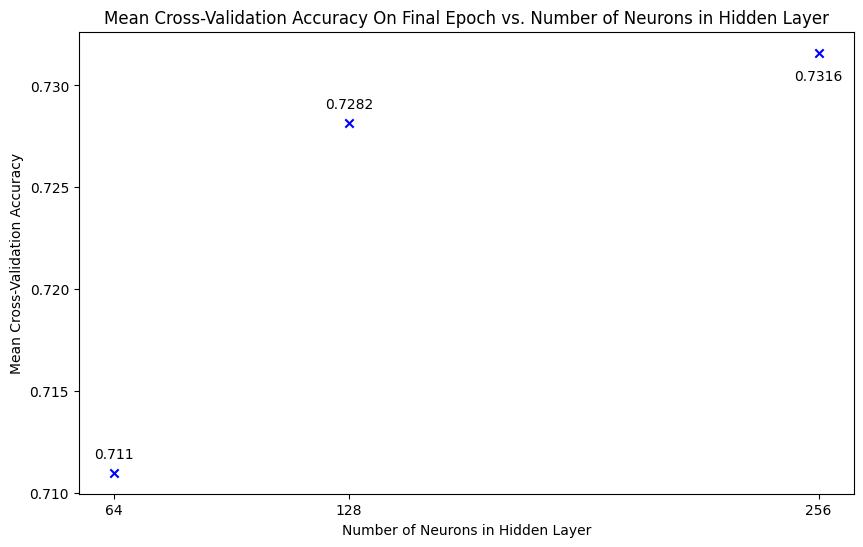

,Number of Neurons in Hidden Layer,Mean CV Time On Last Epoch (seconds),Mean CV Accuracy On Last Epoch
0,64,0.2319,0.7110
1,128,0.2383,0.7282
2,256,0.2451,0.7316


In [6]:
# YOUR CODE HERE

# Plot the mean cross-validation accuracies on the final epoch for different numbers of hidden-layer neurons using a scatter plot.

# Get the keys and values from the dictionary to plot
neurons = list(cross_validation_accuracies.keys())
accuracies = list(cross_validation_accuracies.values())

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(neurons, accuracies, c='blue', marker='x')

# Labeling and titling the graph
plt.xlabel('Number of Neurons in Hidden Layer')
plt.ylabel('Mean Cross-Validation Accuracy')
plt.title('Mean Cross-Validation Accuracy On Final Epoch vs. Number of Neurons in Hidden Layer')
plt.xticks(neurons)  # Set x-ticks to be the actual numbers of neurons considered

# Annotate each point with its accuracy value
for i, txt in enumerate(accuracies):
    if i == 2:
        plt.annotate(
            round(txt, 4), 
            (neurons[i], accuracies[i]), 
            textcoords="offset points",  # specify textcoords as offset points
            xytext=(0, -20),  # 0 points in x direction,-20 points in y direction
            ha='center'  # horizontally align the text to be centered
        )
    else:
        plt.annotate(
            round(txt, 4), 
            (neurons[i], accuracies[i]), 
            textcoords="offset points",  # specify textcoords as offset points
            xytext=(0, 10),  # 0 points in x direction, 10 points in y direction
            ha='center'  # horizontally align the text to be centered
        )

# Show the graph
plt.show()

data = {
    'Number of Neurons in Hidden Layer': list(cross_validation_times.keys()),
    'Mean CV Time On Last Epoch (seconds)': list(cross_validation_times.values()),
    'Mean CV Accuracy On Last Epoch': list(cross_validation_accuracies.values())
}

# Create DataFrame
df = pd.DataFrame(data)
pd.set_option('display.width', 200)  # set the display width for columns

# Round the specified columns to 4 decimal places
df['Mean CV Time On Last Epoch (seconds)'] = df['Mean CV Time On Last Epoch (seconds)'].round(4)
df['Mean CV Accuracy On Last Epoch'] = df['Mean CV Accuracy On Last Epoch'].round(4)

# Display DataFrame
display(df)

# Please note that the next time you run this notebook cell, the results will be different as time taken depends on CPU speed and other factors.

5. Select the optimal number of neurons for the hidden layer. State the rationale for your selection.

In [28]:
optimal_neurons = 256
reason = '''
• Our main objective when optimizing the model is to achieve the highest possible accuracy. In our experiments, increasing the number of neurons in the first hidden layer from 64 to 256 showed 
a consistent increase in mean cross-validation accuracy on the last epoch. The configuration with 256 neurons achieved an accuracy of 0.7316, the highest among all the configurations tested.

• We have incorporated various strategies and architectures, like dropout layers, to safeguard our model against overfitting. Additionally, with the use of early stopping during training and 
implementing cross-validation, we have measures in place to ensure the model's robustness and its generalizability to unseen data. With these strategies, the increased complexity of our model 
with more neurons becomes both justifiable and beneficial, allowing us to harness a more complex model to capture intricate patterns in the data without a high risk of overfitting.

• When balancing model complexity and computational resources, it's evident that an increase in the number of neurons does lead to a slightly higher computational time. However, the incremental 
increase in time, from 0.2592 seconds for 64 neurons to 0.2835 seconds for 256 neurons, is relatively minor, especially when contrasted with the significant improvement in accuracy: from 0.7110 
with 64 neurons to 0.7316 with 256 neurons.

• Even though there is an increase in computational time as we transition from 64 to 256 neurons, the marginal difference in training time is outweighed by the considerable enhancement in model 
accuracy. This makes the choice of 256 neurons in the first hidden layer as the optimal configuration both judicious and favorable for our application.
'''
# YOUR CODE HERE

print(f"Optimal number of neurons in the first hidden layer: {optimal_neurons}")
print()
print(f"Reason: {reason}")


Optimal number of neurons in the first hidden layer: 256

Reason: 
• Our main objective when optimizing the model is to achieve the highest possible accuracy. In our experiments, increasing the number of neurons in the first hidden layer from 64 to 256 showed 
a consistent increase in mean cross-validation accuracy on the last epoch. The configuration with 256 neurons achieved an accuracy of 0.7316, the highest among all the configurations tested.

• We have incorporated various strategies and architectures, like dropout layers, to safeguard our model against overfitting. Additionally, with the use of early stopping during training and 
implementing cross-validation, we have measures in place to ensure the model's robustness and its generalizability to unseen data. With these strategies, the increased complexity of our model 
with more neurons becomes both justifiable and beneficial, allowing us to harness a more complex model to capture intricate patterns in the data without a high ri

6. Plot the train and test accuracies against training epochs with the optimal number of neurons using a line plot.

Training the model with optimal number of neurons: 256...
This will stop at 26 epochs (~ 20 secs)...



  0%|          | 0/100 [00:00<?, ?it/s]

 25%|██▌       | 25/100 [00:10<00:30,  2.48it/s]

Early stopping triggered at epoch 26!
Training completed!

Training Accuracies:
Epoch 10: 0.7349
Epoch 20: 0.8266
Epoch 26: 0.8573

Test Accuracies:
Epoch 10: 0.7051
Epoch 20: 0.7515
Epoch 26: 0.7593


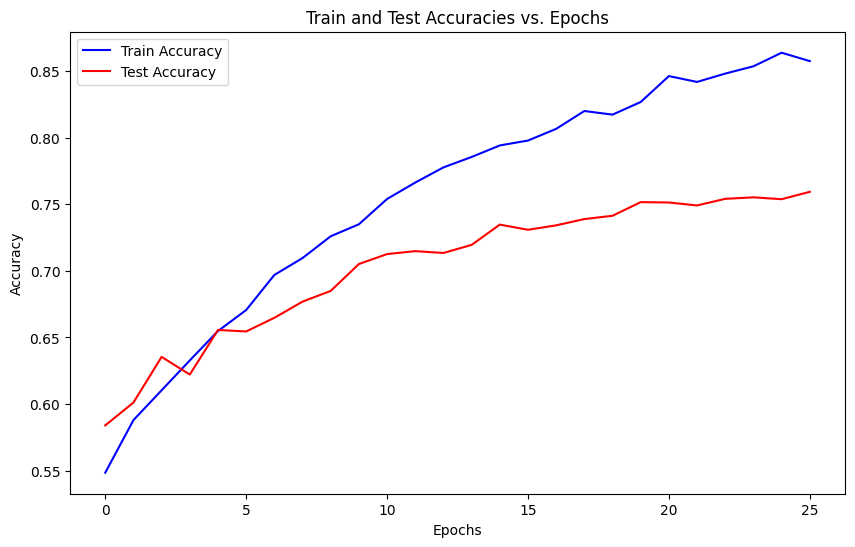

In [7]:
# YOUR CODE HERE

# Now, use the full training dataset and train the model using the optimal number of neurons and test it on the test set:
set_seed(SEED)
optimal_neurons = 256
no_input_features = X_train.shape[1]
no_hidden = optimal_neurons
no_labels = 1
batch_size = 256
model_optimal = MLP(no_input_features, no_hidden, no_labels)
# Saved the trained model for usage in A4
torch.save(model_optimal.state_dict(), 'a3_model.pth')

X_train_scaled, X_test_scaled = preprocess_dataset(X_train, X_test)

# Assuming train_accuracies and test_accuracies are lists containing accuracy values for each epoch
print(f'Training the model with optimal number of neurons: {optimal_neurons}...')
print('This will stop at 26 epochs (~ 20 secs)...')
print()
train_accuracies, train_losses, test_accuracies, test_losses , _ = train(
    model_optimal, X_train_scaled, y_train, X_test_scaled, y_test, batch_size
)
print('Training completed!')

# Print training accuracies every 10 epochs and the last epoch
print("\nTraining Accuracies:")
for i, accuracy in enumerate(train_accuracies, 1):  # Enumerate starts the count from 1 here
    if i % 10 == 0 or i == len(train_accuracies):
        print(f"Epoch {i}: {accuracy:.4f}")

# Print testing accuracies every 10 epochs and the last epoch
print("\nTest Accuracies:")
for i, accuracy in enumerate(test_accuracies, 1):
    if i % 10 == 0 or i == len(test_accuracies):
        print(f"Epoch {i}: {accuracy:.4f}")

# Create a line plot
plt.figure(figsize=(10, 6))

# Plotting the training accuracies
plt.plot(range(len(train_accuracies)), train_accuracies, label='Train Accuracy', color='b')

# Plotting the test accuracies
plt.plot(range(len(test_accuracies)), test_accuracies, label='Test Accuracy', color='r')

# Labeling and titling the graph
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracies vs. Epochs')
plt.legend()

# Show the graph
plt.show()

#---------------------------------------#
# Comments:
# • Convergence and Learning: The training accuracy showed significant improvement as epochs progressed, starting from 0.7349 in the 10th epoch and reaching 0.8573 by the 26th epoch. 
#   This consistent rise in training accuracy indicates that the model efficiently adapted its weights over time, improving its performance on the training dataset.

# • Generalization: The test accuracy demonstrated a similar upward trajectory, rising from 0.7051 in the 10th epoch to 0.7593 by the 26th epoch. Howver, the test and training accuracies did not remain closely 
#   aligned throughout the training process, underscoring the model's inability to generalize well to new, unseen data. Particularly in the final epoch, the test accuracy (0.7593) is nearly 0.1 away from 
#   to the training accuracy (0.8573), further emphasizing the model's moderate generalization capabilities.

# • Early Stopping: The training was halted on the 26th epoch, suggesting that the early stopping criterion was activated. This mechanism is pivotal in averting potential overfitting by ensuring the model 
#   doesn't become overly specialized to the training data, which could compromise performance on the test dataset. The fact that the model stopped training at this point indicates that subsequent 
#   epochs might not have yielded notable advancements or could have even deteriorated the model's capacity to generalize.
#---------------------------------------#
